In [1]:
# root to folder with the two trial stks

import os

# on CTN RAS
# basedir = 'C:\\Users\\rasmu\\Desktop\\TEMP LOCAL FILES'

# On PERSONAL PROCESSING RAS
basedir = 'C:\\Users\\rasmu\\OneDrive\\Desktop\\TEMP LOCAL FILES'

flddir = 'FXX\\980nm_PreStim60s_pls15_fps6_w05avg\\STKS'

rtdir = os.path.join(basedir,flddir)

# OBS: frameRate="30.043"
# dwellTime="0.08"
# averageNum="5" 

# PS: shutter in MV bPAC protocol starts after 60s exactly (first black frame)

In [2]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def process_tif_stack(filepath, t1, t2, t3, t4):
    """
    Reads a .tif stack, calculates ratios, and generates heatmaps.

    Args:
        filepath: Path to the .tif stack file.
        t1, t2, t3, t4: Time points defining the ranges for ratio calculation.

    Returns:
        A tuple containing:
            - ratio_heatmap: Heatmap of the calculated ratios.
            - avg_heatmap: Heatmap of the average values of the original stack.
            - original_shape: Shape of the original stack.
    """
    try:
        with tifffile.TiffFile(filepath) as tif:
            image_stack = tif.asarray()
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None, None, None
    except Exception as e:
        print(f"Error reading TIFF file: {e}")
        return None, None, None

    original_shape = image_stack.shape
    z_size, y_size, x_size = original_shape

    # Calculate average stack
    avg_stack = np.mean(image_stack, axis=0)

    num_vectors = y_size * x_size
    data_matrix = np.zeros((num_vectors, z_size), dtype=image_stack.dtype)
    indices = np.zeros((num_vectors, 2), dtype=int)

    vector_index = 0
    for y in range(y_size):
        for x in range(x_size):
            z_vector = image_stack[:, y, x]
            data_matrix[vector_index, :] = z_vector
            indices[vector_index, :] = [x, y]
            vector_index += 1

    ratio_heatmap = np.zeros((y_size, x_size))
    for i in range(num_vectors):
        x, y = indices[i]
        vec = data_matrix[i, :]
        avg_a = np.mean(vec[t1:t2+1])  # +1 because slicing is exclusive of the end
        avg_b = np.mean(vec[t3:t4+1])
        if avg_b != 0: # Avoid division by zero
            ratio = avg_a / avg_b
        else:
            ratio = 0 # Or some other appropriate value/handling for zero division

        ratio_heatmap[y, x] = ratio # Note: y, x order for image indexing

    avg_heatmap = np.mean(image_stack, axis=0)  # Average across the z-axis

    return ratio_heatmap, avg_heatmap, original_shape


In [4]:
pip install skimage

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [3 lines of output]
  
  *** Please install the `scikit-image` package (instead of `skimage`) ***
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
from skimage import exposure 

# Example usage:
filepath_A = os.path.join(rtdir,'ChanA_stk.tif') # Replace with your file path
t1a = 40  # Example values - replace with your desired time points
t2a = 90
t3a = 100
t4a = 150
# Example usage:
filepath_B = os.path.join(rtdir,'ChanB_stk.tif') # Replace with your file path
t1b = 40  # Example values - replace with your desired time points
t2b = 50
t3b = 80
t4b = 90

ratio_heatmap_a, avg_heatmap_a, original_shape_a = process_tif_stack(filepath_A, t1a, t2a, t3a, t4a)
ratio_heatmap_b, avg_heatmap_b, original_shape_b = process_tif_stack(filepath_B, t1b, t2b, t3b, t4b)

if ratio_heatmap_a is not None:
    # Display the heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Contrast Stretching (using skimage.exposure)
    p2, p98 = np.percentile(ratio_heatmap_a, (2, 98)) # Calculate percentiles for stretching
    ratio_heatmap_a_stretched = exposure.rescale_intensity(ratio_heatmap_a, in_range=(p2, p98)) # Stretch

    p2, p98 = np.percentile(avg_heatmap_a, (2, 98)) # Calculate percentiles for stretching
    avg_heatmap_a_stretched = exposure.rescale_intensity(avg_heatmap_a, in_range=(p2, p98)) # Stretch

    p2, p98 = np.percentile(ratio_heatmap_b, (2, 98)) # Calculate percentiles for stretching
    ratio_heatmap_b_stretched = exposure.rescale_intensity(ratio_heatmap_b, in_range=(p2, p98)) # Stretch

    p2, p98 = np.percentile(avg_heatmap_b, (2, 98)) # Calculate percentiles for stretching
    avg_heatmap_b_stretched = exposure.rescale_intensity(avg_heatmap_b, in_range=(p2, p98)) # Stretch


    im1 = axes[0, 0].imshow(ratio_heatmap_a_stretched, cmap='viridis')  # Use stretched data
    axes[0, 0].set_title("Ratio Heatmap ChanA")
    fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.03)

    im2 = axes[0, 1].imshow(avg_heatmap_a_stretched, cmap='viridis')  # Use stretched data
    axes[0, 1].set_title("Average Heatmap ChanA")
    fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.03)

    im3 = axes[1, 0].imshow(ratio_heatmap_b_stretched, cmap='viridis')  # Use stretched data
    axes[1, 0].set_title("Ratio Heatmap ChanB")
    fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.03)

    im4 = axes[1, 1].imshow(avg_heatmap_b_stretched, cmap='viridis')  # Use stretched data
    axes[1, 1].set_title("Average Heatmap ChanB")
    fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.03)

    plt.tight_layout()
    plt.show()
else:
    print("Failed to process the TIFF stack.")

ModuleNotFoundError: No module named 'skimage'

Text(0, 0.5, 'Frequency')

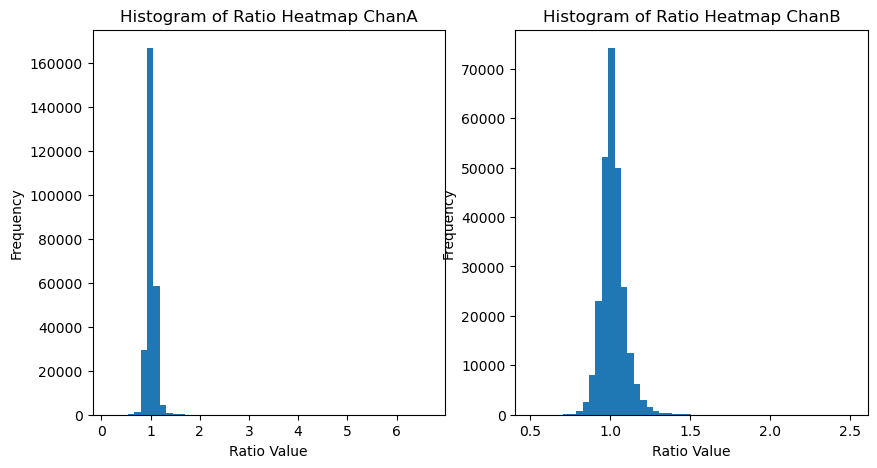

In [7]:
# --- Histogram Plots ---
fig_histograms, axes_histograms = plt.subplots(1, 2, figsize=(10, 5))  # Separate figure for histograms

axes_histograms[0].hist(ratio_heatmap_a.ravel(), bins=50)
axes_histograms[0].set_title("Histogram of Ratio Heatmap ChanA")
axes_histograms[0].set_xlabel("Ratio Value")
axes_histograms[0].set_ylabel("Frequency")

axes_histograms[1].hist(ratio_heatmap_b.ravel(), bins=50)
axes_histograms[1].set_title("Histogram of Ratio Heatmap ChanB")
axes_histograms[1].set_xlabel("Ratio Value")
axes_histograms[1].set_ylabel("Frequency")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

def visualize_top_pixels(tif_path, ratio_heatmap, avg_heatmap, original_shape):
    """Visualizes top pixels and activity traces from a TIFF stack.

    Args:
        tif_path: Path to the TIFF stack.
        ratio_heatmap: 2D numpy array of ratio values.
        avg_heatmap: 2D numpy array of average values (not used here).
        original_shape: Tuple (y, x) of original image dimensions.
    """

    try:
        stack = tifffile.imread(tif_path)
    except FileNotFoundError:
        print(f"Error: TIFF file not found at {tif_path}")
        return

    # Flatten ratio_heatmap and get indices of top 1000 pixels
    flat_ratio = ratio_heatmap.flatten()
    top_1000_indices = np.argsort(flat_ratio)[-1000:]

    # Get (y, x) coordinates of top pixels
    # FIX: Take only the last two dimensions of original_shape!
    y_coords, x_coords = np.unravel_index(top_1000_indices, original_shape[-2:])  # corrected line

    # Extract activity traces for top pixels
    activity_traces = stack[:, y_coords, x_coords]

    # Normalize activity traces
    normalized_traces = (activity_traces - np.min(activity_traces, axis=0)) / (
        np.max(activity_traces, axis=0) - np.min(activity_traces, axis=0) + 1e-6
    )

    # Create the mask for the original image
    mask = np.zeros(original_shape[-2:], dtype=bool)  # Corrected line
    mask[y_coords, x_coords] = True

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Subplot 1: Heatmap of normalized activity traces
    im1 = axes[0].imshow(normalized_traces.T, cmap='viridis', aspect='auto')
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Pixel (Top 1000)")
    axes[0].set_title("Normalized Activity Traces (Top 1000 Pixels)")
    fig.colorbar(im1, ax=axes[0], label="Normalized Activity")

    # Subplot 2: Masked original image
    masked_image = np.ones(original_shape[-2:])  # Corrected line
    masked_image[mask] = 0  # Black for top pixels
    axes[1].imshow(masked_image, cmap='gray')
    axes[1].set_title("Top 1000 Pixels Highlighted")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# ... (Example usage remains the same)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

def visualize_top_pixels(tif_path, ratio_heatmap, avg_heatmap, original_shape, fps=0.625):
    """Visualizes top pixels and activity traces from a TIFF stack.

    Args:
        tif_path: Path to the TIFF stack.
        ratio_heatmap: 2D numpy array of ratio values.
        avg_heatmap: 2D numpy array of average values.
        original_shape: Tuple (y, x) of original image dimensions.
        fps: Frames per second. Defaults to 0.625.
    """

    try:
        stack = tifffile.imread(tif_path)
    except FileNotFoundError:
        print(f"Error: TIFF file not found at {tif_path}")
        return

    flat_ratio = ratio_heatmap.flatten()
    top_1000_indices = np.argsort(flat_ratio)[-1000:]

    y_coords, x_coords = np.unravel_index(top_1000_indices, original_shape[-2:])

    activity_traces = stack[:, y_coords, x_coords]

    normalized_traces = (activity_traces - np.min(activity_traces, axis=0)) / (
        np.max(activity_traces, axis=0) - np.min(activity_traces, axis=0) + 1e-6
    )

    mask = np.zeros(original_shape[-2:], dtype=bool)
    mask[y_coords, x_coords] = True

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    time_points = np.arange(stack.shape[0]) / fps
    im1 = axes[0].imshow(normalized_traces.T, cmap='viridis', aspect='auto', extent=[time_points[0], time_points[-1], 0, normalized_traces.shape[1]])
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Pixel (Top 1000)")
    axes[0].set_title("Normalized Activity Traces (Top 1000 Pixels)")
    fig.colorbar(im1, ax=axes[0], label="Normalized Activity")

    masked_image = np.ones(original_shape[-2:])
    masked_image[mask] = 0
    axes[1].imshow(masked_image, cmap='gray')
    axes[1].set_title("Top 1000 Pixels Highlighted")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return activity_traces, normalized_traces


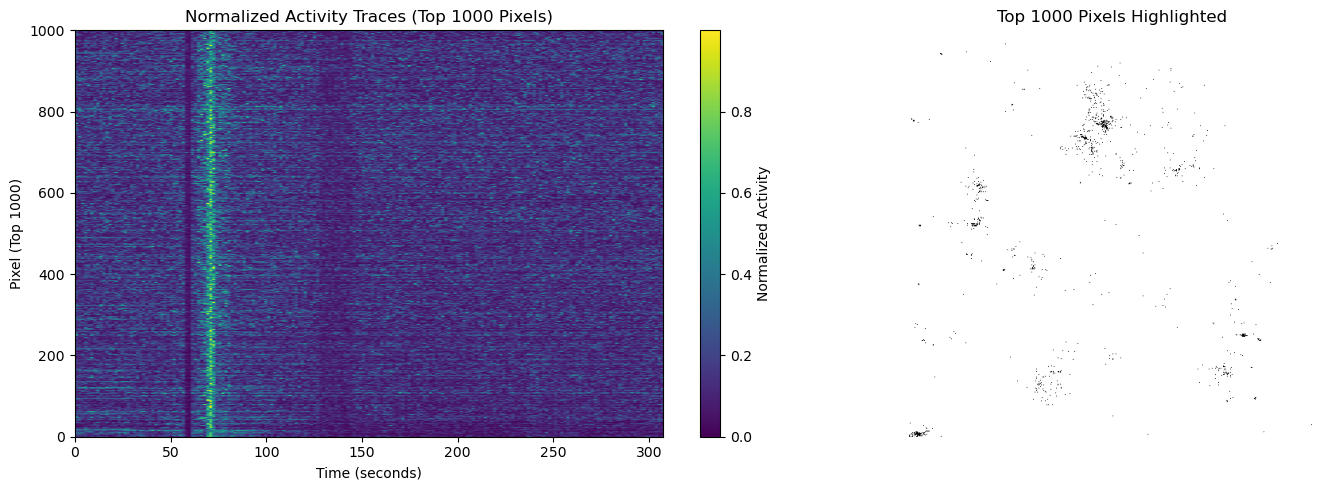

In [19]:
# Example Usage (assuming you have already calculated ratio_heatmap, etc.)
tif_file_path = os.path.join(basedir,flddir,'ChanB_stk.tif')

activity_traces_b, normalized_traces_b = visualize_top_pixels(tif_file_path, ratio_heatmap_b, avg_heatmap_b, original_shape_b, fps=0.625)

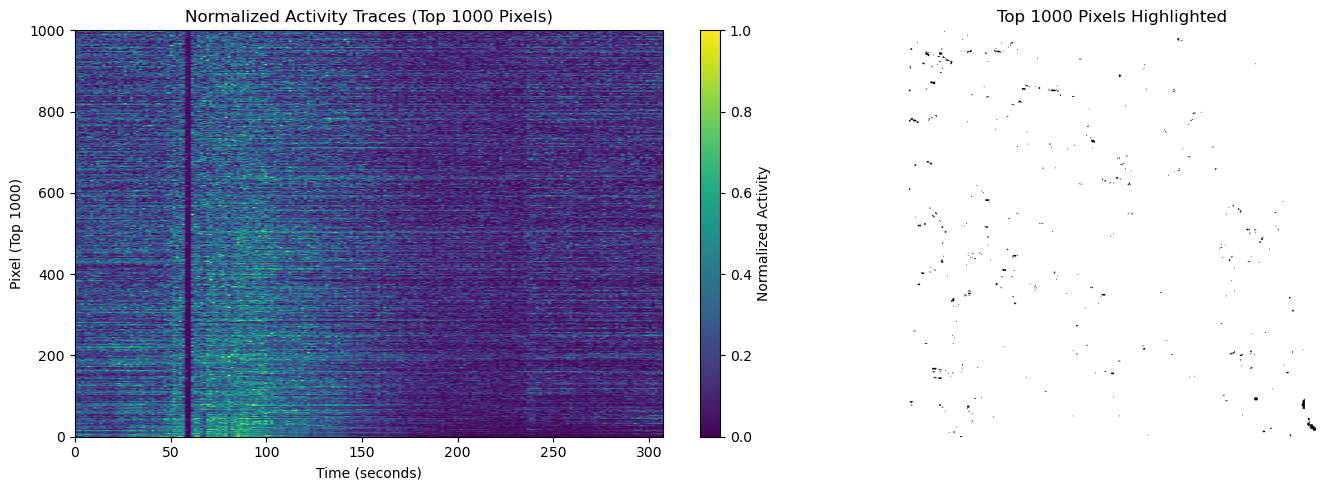

In [21]:
# Example Usage (assuming you have already calculated ratio_heatmap, etc.)
tif_file_path = os.path.join(basedir,flddir,'ChanA_stk.tif')

activity_traces_a, normalized_traces_a = visualize_top_pixels(tif_file_path, ratio_heatmap_a, avg_heatmap_a, original_shape_a, fps=0.625)

Next Steps:

1) Make assisting plots of the coactivity in the pxl_ROIs rasters

2) Define single Islets of pxl_ROIs by coherence

3) Incrementally expand the area of each of these islets and observe how the co-activity graphs for each islet changes, as more pxl are taken into the area in question

4) Mark the islets that are only found in ChanB as green, ChanA as red, and the overlapping Islets as Yellow
- NB: We need yellow. Prefereably with good cAMP signal.

5) 



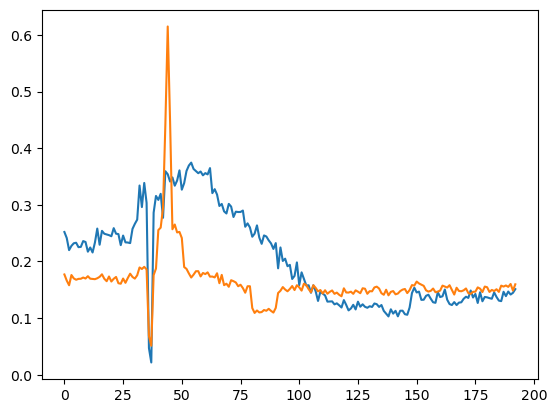

In [51]:
# Input for point 1 - plotting coactivities of islets (for now, full FOVs)

plt.plot(np.mean(normalized_traces_a,1))
plt.plot(np.mean(normalized_traces_b,1))

In [53]:
# Point 2: Defining single Islets of pxl_ROIs by coherence

# Suggestion 1: screen ROI-spaces within loop.

# For each positively identified pxl (0.81um/pxl), screen the area around the pxl for 10pxl in each planar direction (+- 8um ~somatic signal).
# If more than a set threshold value (e.g. 40%) is positively identified within this area

# Suggestion 2: k-means clustering with Elbow method for optimal separation of clusters
# - visualize, approve, show Co-Activity plots for each of 

# automate outline drawing to collect the pixels needed to combine the included pxls
# - Local visualization: ROI, Area (pxls + metric), Shape (2-dimensional), CoActivities within ROI (!)
# NB: Since matching ROIs are needed, show CoActivities for both channels overlapping

# - Global visualization: ChanB-ROIs, ChanA-ROIs and overlaps
# numbers to identify

# NB: Leave room for ROI-modification (including expansion and colocalization enabling, as well as pruning off convolving non-specific signals)
# Initiate a special pruning window:
# Zoomed in to fit the single ROI centered plus 16um (20pxl) in each direction
# Co-plot closely residing ROIs from each channel

# Subtract/Add functionality the Co-Activity Plot (with proper converted x-axis timescale)
# Output:
# Needs a class structure for each ROI?
# To continuously add/subtract pxl to the ROIs
# Q: Are the ROIs then Superclasses, while the individual pxls are subclasses (associated with traces in each Channel, x,y-locations)

# NB: Considering the common use of the GFAP-promotor, a central requirement would be that the ROIs from ChanA and ChanB are 100% matching
